<a href="https://colab.research.google.com/github/drwitt/BME_590_Tensorflow_Deep_Learning/blob/master/Danny_ResNet_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the necessary packages
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD

import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
        

Using TensorFlow backend.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.__version__

'1.14.0'

## Import Dog Image Dataset:

In [2]:
ds = tfds.load('oxford_iiit_pet')

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/1.1.0. Subsequent calls will reuse this data.


In [0]:
ds_train = ds['train'].map(lambda ele: (tf.image.resize_image_with_pad(ele['image'], 224, 224), ele['label']))

#for x,y in ds_train: break
#plt.imshow(x.numpy().round().astype('uint8'))

In [0]:
def generator(samples, batch_size=32,shuffle_data=True,resize=224):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    dim = tf.constant([224, 224], dtype=tf.int32)
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img = batch_sample[0]
                label = batch_sample[1]
                
                # apply any kind of preprocessing
                tf.image.resize_images(img, dim)
                # Add example to arrays
                X_train.append(img)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

In [0]:
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

In [0]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))

In [9]:
for image, label in ds_train.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

AttributeError: ignored

Label: 22


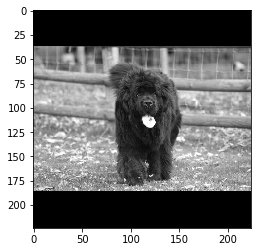

In [0]:
for pet_example in ds_train.take(1):  # Only take a single example
    image, label = pet_example[0], pet_example[1]

    plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))
    print("Label: %d" % label.numpy())

In [0]:
#Make generator:

ds_train_datagen = generator(ds_train ,batch_size=8, shuffle_data=True)

## Construct ResNet Class and Model Build Specifications:

In [0]:
class ResNet(Model):
    @staticmethod
    def residual_module(data, K, stride, chanDim, red=False, 
        reg=0.0001, bnEps=2e-5, bnMom=0.9):
        # the shortcut branch of the ResNet module should be
        # initialize as the input (identity) data
        shortcut = data
  
        # the first block of the ResNet module are the 1x1 CONVs
        bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(data)
        act1 = Activation("relu")(bn1)
        conv1 = Conv2D(int(K * 0.25), 
                       (1, 1), 
                       use_bias=False, 
                       kernel_regularizer=l2(reg))(act1)
    
        # the second block of the ResNet module are the 3x3 CONVs
        bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv1)
        act2 = Activation("relu")(bn2)
        conv2 = Conv2D(int(K * 0.25), 
                       (3, 3), 
                       strides=stride, 
                       padding="same", 
                       use_bias=False,
                       kernel_regularizer=l2(reg))(act2)

        # the third block of the ResNet module is another set of 1x1 CONVs
        bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(conv2)
        act3 = Activation("relu")(bn3)
        conv3 = Conv2D(K, 
                       (1, 1),
                       use_bias=False,
                       kernel_regularizer=l2(reg))(act3)

        # if we are to reduce the spatial size, apply a CONV layer to the shortcut
        if red:
            shortcut = Conv2D(K, 
                           (1, 1), 
                           strides=stride, 
                           use_bias=False,
                           kernel_regularizer=l2(reg))(act1)

        # add together the shortcut and the final CONV
        x = add([conv3, shortcut])

        # return the addition as the output of the ResNet module
        return x
      
    @staticmethod
    def build(width, height, depth, classes, stages, filters, reg=0.0001, 
              bnEps=2e-5, bnMom=0.9):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        # set the input and apply BN
        inputs = Input(shape=inputShape)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
          momentum=bnMom)(inputs)

        # apply CONV => BN => ACT => POOL to reduce spatial size
        x = Conv2D(filters[0], (5, 5), use_bias=False,
                   padding="same", kernel_regularizer=l2(reg))(x)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                               momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = ZeroPadding2D((1, 1))(x)
        x = MaxPooling2D((3, 3), strides=(2, 2))(x)

        # loop over the number of stages
        for i in range(0, len(stages)):
            # initialize the stride, then apply a residual module
            # used to reduce the spatial size of the input volume
            stride = (1, 1) if i == 0 else (2, 2)
            x = ResNet.residual_module(x, filters[i + 1], stride,
                chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

            # loop over the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a ResNet module
                x = ResNet.residual_module(x, filters[i + 1],
                    (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

        # apply BN => ACT => POOL
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                               momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = AveragePooling2D((8, 8))(x)
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer=l2(reg))(x)
        x = Activation("softmax")(x)

        # create the model
        model = Model(inputs, x, name="resnet")

        # return the constructed network architecture
        return model
        

## Build Classifier According to ResNet Paper and Compile:

In [0]:
# define the # of epochs, initial learning rate and batch size
num_epochs = 50
init_lr= 1e-1
bs = 32

# initialize our ResNet model and compile it:
model = ResNet.build(width = 64, 
                     height = 64,
                     depth = 3,
                     classes = 2,
                     stages = (3, 4, 6),
                     filters = (64, 128, 256, 512),
                     reg=0.0005)

opt = SGD(lr=init_lr, momentum=0.9)

model.compile(loss="binary_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

## Compile and Fit Classification Model:

In [27]:
model.fit(ds_train_datagen,
          epochs=20,
          steps_per_epoch = 10)

history = model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_sample/batch_size),  
        epochs=epochs,
        verbose=1)

Epoch 1/20


TypeError: ignored

In [0]:
Resnet50_model.load_weights('saved_models/weights.best.ResNet50.hdf5')
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_DogResnet50]
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

## Predict Image Class Using Model:

In [0]:
from extract_bottleneck_features import *
def dog_breed(img_path):
  = extract_Resnet50(path_to_tensor(img_path))
predicted_vector = Resnet50_model.predict(bottleneck_feature)
return dog_names[np.argmax(predicted_vector)

In [0]:
from extract_bottleneck_features import *
def dog_breed(img_path):
  = extract_Resnet50(path_to_tensor(img_path))
predicted_vector = Resnet50_model.predict(bottleneck_feature)
return dog_names[np.argmax(predicted_vector)